# Assignment 3: Cross Modal Search [190]

Done by Evgeny Bobkunov, e.bobkunov@innopolis.university

In the process of solving the assignment, I discussed approaches and problems with other students. I collaborated with Matvey Korinenko, Svyatoslav Svyatkin, Sofia Gamershmidt and Gleb Bugaev on approaches to LSH implementation.

In this assignment, we'll introduce cross-modal search. We'll work with a dataset of images and their corresponding captions, where each image is associated with multiple descriptive captions. Our goal is to learn how to create contextual embeddings for different modalities (images and text) and build an efficient search mechanism that allows us to seamlessly navigate between these modalities. This will enable performing image-to-image, image-to-text, text-to-text, and text-to-image searches.

In [23]:
!pip -q install datasets

import warnings
import numpy as np
import torch
from tqdm import tqdm
import heapq
import time
import pprint
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Union, Generator

warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Dataset Loading and Exploration



Please download the dataset from the following link: [Dataset](https://drive.google.com/file/d/19KPsmsNhj6Q-W6yfYHud2K8EfPdWU2mc/view?usp=sharing).
Once downloaded, you can load and manage the data using the datasets library from Hugging Face.

In [24]:
from datasets import load_from_disk

dataset_path = "task_dataset"

ds = load_from_disk(dataset_path)

After running this code, you should observe that the dataset contains 15,000 images, each associated with a list of captions. Familiarizing yourself with the dataset structure is essential for the embedding generation and search tasks.

In [25]:
ds

Dataset({
    features: ['url', 'sentences'],
    num_rows: 15000
})

## Image Embedding Generation [10]

After loading the dataset, the next step is to create meaningful representations of the images in a vector format – image embeddings. These embeddings will capture the semantic essence of the images and enable you to perform similarity comparisons. You have the freedom to choose any embedding method that suits your needs like CNN pretraiend methods or VITs, etc..., but consider its effectiveness for similarity search.
Ensure you embed all images in the dataset using the same chosen method to maintain a comparable embedding space.



---


**Important Note**: It is not allowed to use the same embedding method for image and text, they should be different methods but it's totally fine and recommended if the vector dimensions after embedding of text and image are the same size.

Below find two helper functions to streamline the image loading and embedding process.

In [26]:
from torchvision import models, transforms
import torch
from PIL import Image
import requests
from io import BytesIO

model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [27]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image_from_url(url: str) -> np.ndarray:
    """
    Loads an image from a given URL and converts it to an RGB NumPy array.
    """
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return np.array(image)

def encode_image(image_url: str) -> np.ndarray:
    """
    Encodes a given image URL into an embedding vector.
    """
    image = load_image_from_url(image_url)
    image_tensor = transform(Image.fromarray(image)).unsqueeze(0)

    with torch.no_grad():
        embedding = model(image_tensor).squeeze().numpy()
    return embedding


In [28]:
print(ds)
print(ds.column_names)
print(ds[0])

Dataset({
    features: ['url', 'sentences'],
    num_rows: 15000
})
['url', 'sentences']
{'url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000551159.jpg', 'sentences': ['A young boy snowboards down a snowy track.', 'an image of a person skateboarding in the middle of winter', 'A kid rides on some sort of a ski track through the snow. ', 'A small child in a helmet learning how to ski', 'A small child using skis to ski down the hill.']}


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from PIL import Image
import requests
from io import BytesIO

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()
model.to("cuda")

class ImageDataset(Dataset):
    def __init__(self, urls):
        self.urls = urls

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        url = self.urls[idx]
        try:
            response = requests.get(url)
            image = Image.open(BytesIO(response.content)).convert("RGB")
            return transform(image)
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return torch.zeros(3, 224, 224)

batch_size = 32
urls = [example['url'] for example in ds]
dataset = ImageDataset(urls)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

image_embeddings = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        batch = batch.to("cuda")
        embeddings = model(batch).squeeze(-1).squeeze(-1)
        image_embeddings.append(embeddings.cpu().numpy())

image_embeddings = np.concatenate(image_embeddings, axis=0)

np.save("image_embeddings.npy", image_embeddings)


In [10]:
image_embeddings = np.load("image_embeddings.npy")

## Text Embedding Generation [20]

Similar to what you did when you created embeddings for images, you now need to generate embeddings for the text captions. It's important to consider the multi-caption nature of the data, each image has multiple associated captions, and you should represent this effectively in the text embeddings. Similar to the choice made with image dimension size you should maintain consistency of text dimension embeddign, choosing a good way to embed all captions per image is important to achieve good results.

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()
model.to("cuda")

class TextDataset(Dataset):
    def __init__(self, captions):
        self.captions = captions

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        return self.captions[idx]

def encode_text(captions: List[List[str]]) -> List[np.ndarray]:
    """
    Encodes a list of captions (one list per image) into a list of text embeddings.

    Args:
        captions: A list of lists, where each inner list contains captions for a single image.

    Returns:
        A list of NumPy arrays, where each array represents embedding for an image's captions.
    """
    embeddings = []

    for caption_set in tqdm(captions):
        tokenized = tokenizer(caption_set, padding=True, truncation=True, return_tensors="pt", max_length=128)
        tokenized = {k: v.to("cuda") for k, v in tokenized.items()}

        with torch.no_grad():
            outputs = model(**tokenized)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            mean_embedding = torch.mean(cls_embeddings, dim=0)
            embeddings.append(mean_embedding.cpu().numpy())

    return embeddings

captions = [example["sentences"] for example in ds]

text_embeddings = encode_text(captions)

text_embeddings = np.array(text_embeddings)

np.save("text_embeddings.npy", text_embeddings)


In [11]:
text_embeddings = np.load("text_embeddings.npy")

## Efficient Similarity Search with KD-Trees [70]

One of the main way to implement KNN is based on KD-Tree. KD-Trees are particularly well-suited for nearest neighbor searches in high-dimensional spaces, making them perfect for finding similar images and text based on their embeddings. The KDTree class provided below enables building the tree and performing efficient queries. It allows you to add data in form of tuples, index for image number, caption number inside of images as first parameter and emebdding as second. It also supports euclidean and cosine distance metric based on provided distance type.

**_build_tree**:
This method recursively builds the KDTree. It selects a dimension based on recursion depth, sorts the points along that dimension, and divides the points into subtrees, creating a hierarchical tree structure

**_search_knn**:
This method performs a k-nearest neighbor search by exploring the tree. It keeps track of the closest points and ensures the most relevant candidates are found by searching both subtrees when needed..

**find_knn**:
This method returns the k-nearest neighbors to a target point. It calls the _search_knn method to gather the neighbors and then sorts and returns them, with an option to include their distances.

**nearest_neighbor**:
This method returns the nearest neighbor(s) to a given target point, using the find_knn method. It can return both the points and their distances or just the points, based on the include_distance flag, **this is the method to be used by the user to retireve nearset neighbors.**

__iter__:
This method allows iteration over all points in the KDTree, providing an easy way to loop through the tree’s points in a structured order.


In [ ]:
import numpy as np
import heapq
from typing import List, Tuple, Dict, Union, Optional, Any, Generator

class KDTree:
    """
    A KD-Tree implementation for efficient nearest neighbor search.
    """

    def __init__(self, points: List[Tuple[int, np.ndarray]], dimension: int, distance_type: str = 'euclidean') -> None:
        """
        Initializes a new KD-Tree and selects the distance metric.

        Args:
            points: A list of (index, embedding) tuples to build the tree from.
            dimension: The dimensionality of the embedding vectors.
            distance_type: The type of distance metric to use ('euclidean' or 'cosine'). Defaults to 'euclidean'.
        """
        self.dimension: int = dimension
        self.root: Optional[Dict[str, Union[Tuple[int, np.ndarray], None, None]]] = None

        if distance_type == 'euclidean':
            # Euclidean distance implementation
            self.distance_func = lambda x, y: np.sqrt(np.sum((x - y) ** 2))
        elif distance_type == 'cosine':
            # Cosine distance implementation
            self.distance_func = lambda x, y: 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
        else:
           raise ValueError("Invalid distance type. Use 'euclidean' or 'cosine'.")

        # Build the tree
        self.root = self._build_tree(points)

    def _build_tree(self, points: List[Tuple[int, np.ndarray]], depth: int = 0) -> Optional[Dict[str, Union[Tuple[int, np.ndarray], Optional[Dict[str, Union[Tuple[int, np.ndarray], None, None]]]]]]:
        """
        Recursively builds the KD-Tree from the input points.

        Args:
            points: The set of points to build the tree from.
            depth: The current depth of the recursion, used to determine which dimension to split along.

        Returns:
            A node in the tree structure, containing information about the point and its child nodes.
        """
        # Base case for the recursion
        if not points:
            return None

        # Select the axis to split on
        axis = depth % self.dimension

        # Sort points based on the selected axis
        points.sort(key=lambda point: point[1][axis])
        
        # Find the median point
        median_idx = len(points) // 2
        median_point = points[median_idx]

        # Create the node
        return {
            'point': median_point,
            'left': self._build_tree(points[:median_idx], depth + 1),
            'right': self._build_tree(points[median_idx + 1:], depth + 1)
        }

    def insert(self, new_point: Tuple[int, np.ndarray]) -> None:
        """
        Inserts a new point into the KD-Tree.

        Args:
            new_point: A tuple (index, embedding) to be added to the Tree.
        """
        def _insert(node, point, depth=0):
            if node is None:
                return {'point': point, 'left': None, 'right': None}
            
            # Select splitting dimension
            axis = depth % self.dimension
            
            # Recursive insertion
            if point[1][axis] < node['point'][1][axis]:
                node['left'] = _insert(node['left'], point, depth + 1)
            else:
                node['right'] = _insert(node['right'], point, depth + 1)
            
            return node
        
        self.root = _insert(self.root, new_point)

    def find_knn(self, target: np.ndarray, k: int, include_distances: bool = True) -> List[Union[Tuple[float, Tuple[int, np.ndarray]], Tuple[int, np.ndarray]]]:
        """
        Finds the k-nearest neighbors to a target point in the KD-Tree.

        Args:
            target: The query embedding.
            k: Number of nearest neighbors to look up.
            include_distances: Whether to return distances between query and neighbors. Default is True.

        Returns:
            List of k-nearest neighbors and optionally distances to those neighbors.
        """
        max_heap = []
        self._search_knn(self.root, target, k, max_heap)
        
        # Sort and process the results
        results = []
        while max_heap:
            dist, point = heapq.heappop(max_heap)
            results.append((dist, point) if include_distances else point)
        
        # Reverse to get ascending order
        return list(reversed(results))

    def _search_knn(self, current_node: Optional[Dict[str, Any]],
                   target_point: np.ndarray, k: int,
                   max_heap: List[Tuple[float, Tuple[int, np.ndarray]]],
                   depth: int = 0) -> None:
        """
        Recursively searches the KD-Tree for the k-nearest neighbors.

        Args:
            current_node: The current node being visited.
            target_point: The query point.
            k: The number of nearest neighbors to find.
            max_heap: A max-heap storing (-distance, (index, point)).
            depth: Recursion depth (used for splitting dimension).
        """
        if current_node is None:
            return

        # Calculate distance to current point
        curr_point = current_node['point']
        dist = self.distance_func(curr_point[1], target_point)

        # Manage heap
        if len(max_heap) < k:
            heapq.heappush(max_heap, (-dist, curr_point))
        elif -dist > max_heap[0][0]:
            heapq.heapreplace(max_heap, (-dist, curr_point))

        # Determine splitting axis
        axis = depth % self.dimension
        
        # Decide which subtree to traverse first
        near_subtree = current_node['left'] if target_point[axis] < curr_point[1][axis] else current_node['right']
        far_subtree = current_node['right'] if near_subtree == current_node['left'] else current_node['left']

        # Recursively search near subtree
        self._search_knn(near_subtree, target_point, k, max_heap, depth + 1)

        # Check if we need to search the far subtree
        if len(max_heap) < k or abs(target_point[axis] - curr_point[1][axis]) < -max_heap[0][0]:
            self._search_knn(far_subtree, target_point, k, max_heap, depth + 1)

    def nearest_neighbor(self, target_point: np.ndarray, k: int = 5, include_distance: bool = True) -> Optional[List[Union[Tuple[float, Tuple[int, np.ndarray]], Tuple[int, np.ndarray]]]]:
        """
        Finds the nearest neighbor to a target point by calling find_knn.

        Args:
            target_point: The query embedding.
            k: Number of nearest neighbors to look up.
            include_distance: Whether to return distances. Default is True.

        Returns:
            Optional list of the nearest points and optionally distances.
        """
        if self.root is None:
            return None
        
        return self.find_knn(target_point, k, include_distance)

    def __iter__(self) -> Generator[Tuple[int, np.ndarray], None, None]:
        """
        Iterates through all stored embeddings with their indices.

        Returns:
            A generator yielding (index, embedding) tuples.
        """
        def _inorder_traversal(node):
            if node is None:
                return
            
            # Left subtree
            yield from _inorder_traversal(node['left'])
            
            # Current node
            yield node['point']
            
            # Right subtree
            yield from _inorder_traversal(node['right'])
        
        yield from _inorder_traversal(self.root)

    def range_query(self, target: Union[np.ndarray, Tuple[int, np.ndarray]], radius: float) -> List[int]:
        """
        Finds all points within a certain radius from the target point.

        Args:
            target: The query embedding.
            radius: The maximum allowable distance from the target point.

        Returns:
            A list of indices within the radius.
        """
        # Ensure we're working with the embedding
        target_embedding = target[1] if isinstance(target, tuple) else target
        
        results = []

        def _recursive_search(node, target_embedding, depth=0):
            if node is None:
                return

            # Check if current point is within radius
            curr_point = node['point']
            dist = self.distance_func(curr_point[1], target_embedding)
            
            if dist <= radius:
                results.append(curr_point[0])

            # Determine splitting axis
            axis = depth % self.dimension

            # Decide which subtree to search
            if target_embedding[axis] - radius <= curr_point[1][axis]:
                _recursive_search(node['left'], target_embedding, depth + 1)
            
            if target_embedding[axis] + radius >= curr_point[1][axis]:
                _recursive_search(node['right'], target_embedding, depth + 1)

        _recursive_search(self.root, target_embedding)
        return results

### Testing KD-Tree on Images Data

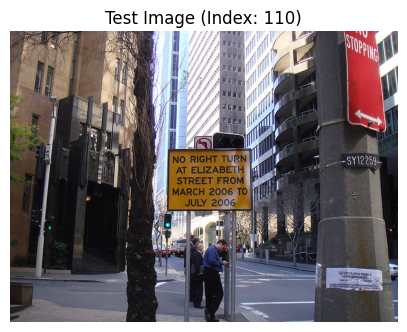

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

test_point = 110

test_image = load_image_from_url(ds["url"][test_point])

plt.figure(figsize=(5, 5))
plt.imshow(test_image)
plt.title(f"Test Image (Index: {test_point})")
plt.axis("off")
plt.show()

In [14]:
test_point = 110
load_image_from_url(ds["url"][test_point])

array([[[ 81,  62,  55],
        [ 99,  90,  93],
        [ 90,  83,  75],
        ...,
        [131, 124, 116],
        [121, 135, 135],
        [ 92, 204, 216]],

       [[ 85,  74,  72],
        [ 94,  94,  86],
        [ 84,  84,  76],
        ...,
        [116, 116, 108],
        [119, 122, 131],
        [101, 178, 208]],

       [[ 91,  63,  75],
        [ 97,  83,  72],
        [100,  80,  79],
        ...,
        [115, 120, 114],
        [116, 129, 137],
        [ 79, 160, 190]],

       ...,

       [[ 40,  63,  69],
        [ 65,  78,  86],
        [ 90,  88,  99],
        ...,
        [ 65,  81, 106],
        [ 75,  87, 113],
        [ 77,  83, 119]],

       [[ 94,  71,  77],
        [ 88,  76,  78],
        [ 79,  79,  79],
        ...,
        [ 68,  90, 111],
        [ 70,  86, 109],
        [ 80,  84, 121]],

       [[ 83,  86,  91],
        [ 87,  88,  93],
        [ 96,  91,  97],
        ...,
        [ 71,  89, 111],
        [ 69,  74, 103],
        [ 82,  70, 116]]

In [15]:
# Build and query the KD-Tree
start = time.time()

# Build the KD-Tree with image embeddings
kdtree = KDTree([(i, emb) for i, emb in enumerate(image_embeddings)], 
                dimension=image_embeddings.shape[1], 
                distance_type='euclidean')

end_build = time.time()

# Search for nearest neighbors
result = kdtree.nearest_neighbor(image_embeddings[test_point], k=6)
end_search = time.time()

# Performance timings
print(f"Time to build the KD-Tree: {end_build - start:.4f} seconds")
print(f"Time to build the KD-Tree and search: {end_search - start:.4f} seconds")

Time to build the KD-Tree: 0.1142 seconds
Time to build the KD-Tree and search: 0.3481 seconds


In [16]:
indices = [idx for idx, _ in [point for _, point in result]] if isinstance(result[0], tuple) else [idx for idx, _ in result]
print("Nearest neighbors indices:", indices)

Nearest neighbors indices: [110, 11694, 2396, 14793, 7113, 1983]


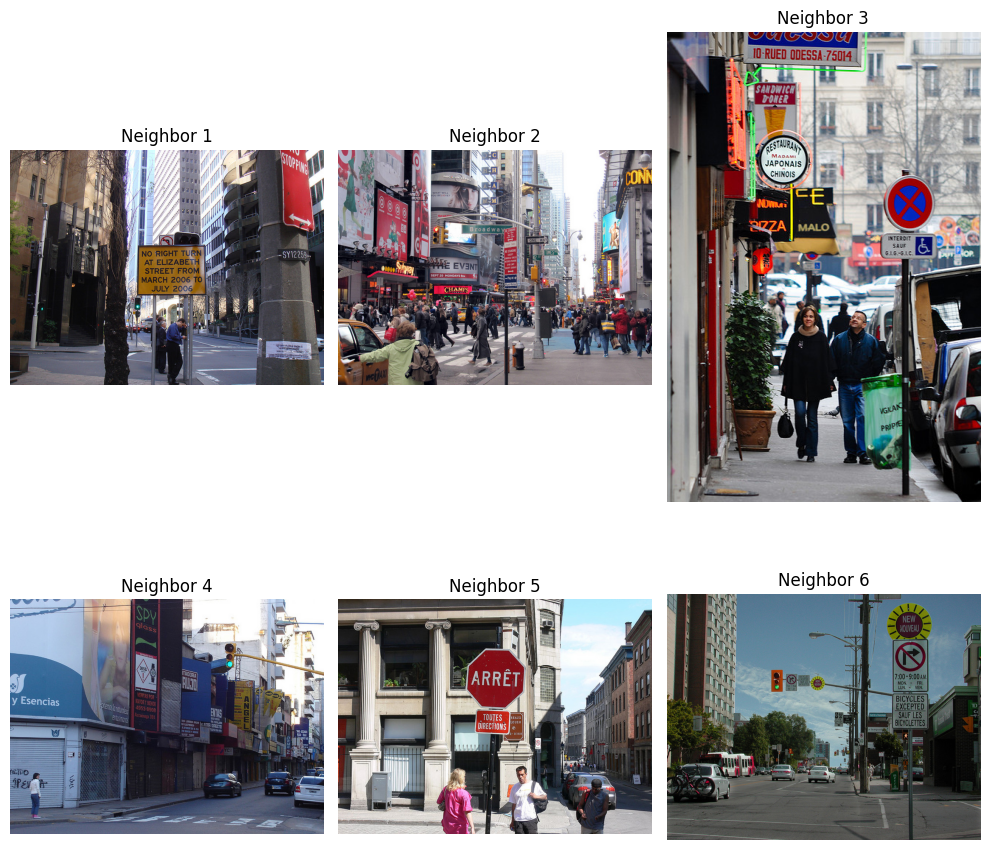

In [17]:
# Display the neighbors
num_neighbors = len(indices)
num_rows = int(num_neighbors**0.5)
num_cols = int(np.ceil(num_neighbors / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_neighbors:
        neighbor_image = load_image_from_url(ds["url"][indices[i]])
        ax.imshow(neighbor_image)
        ax.set_title(f"Neighbor {i + 1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

### Testing KD-Tree on Text Data

In [18]:
test_point = 110
ds["sentences"][test_point]

['A couple of men standing next to a street sign.',
 'A man in a blue shirt stands on a sidewalk in a large city.',
 'a yellow street sign stating when you can turn on a street',
 'a street sign near a tree with buildings in the bakground',
 'Several street signs shown on a city street.']

In [20]:
start = time.time()

# Build the KD-Tree with text embeddings
kdtree = KDTree([(i, emb) for i, emb in enumerate(text_embeddings)], 
                dimension=text_embeddings.shape[1], 
                distance_type='euclidean')

end_build = time.time()

# Retrieve the nearest neighbors for the test point
result = kdtree.nearest_neighbor(text_embeddings[test_point], k=6)
end_search = time.time()

# Timing information
print(f"\nTime to build the KDTree: {end_build - start:.4f} seconds")
print(f"Time to build the KDTree and search: {end_search - start:.4f} seconds")


Time to build the KDTree: 0.1376 seconds
Time to build the KDTree and search: 0.3308 seconds


In [21]:
# Extract neighbor indices
indices = [idx for idx, _ in [point for _, point in result]] if isinstance(result[0], tuple) else [idx for idx, _ in result]
print("\nNearest neighbors indices:", indices, "\n")


Nearest neighbors indices: [110, 6720, 10328, 4284, 11853, 11517] 



In [22]:
# Retrieve and display the captions corresponding to the nearest neighbors
sentences_to_print = [ds["sentences"][i] for i in indices]
print("Nearest neighbors' captions:\n")
pprint.pprint(sentences_to_print, indent=4)

Nearest neighbors' captions:

[   [   'A couple of men standing next to a street sign.',
        'A man in a blue shirt stands on a sidewalk in a large city.',
        'a yellow street sign stating when you can turn on a street',
        'a street sign near a tree with buildings in the bakground',
        'Several street signs shown on a city street.'],
    [   'A car parked on a sidewalk next to a street.',
        'The electronic traffic light is on a street with many parked cars.',
        'A woman walking past a car parked on the sidewalk.',
        'a traffic light on the side walk of a city street',
        'Black and white photograph of traffic lights, car and buildings.'],
    [   'A man with glasses standing at a train station',
        'A male pedestrian on a sidewalk as traffic passes by.',
        'This is a picture of a man standing on a street.',
        'A bicycle rack with a bicycle chained to it on a sidewalk.',
        'LOOKS LIKE A CITY BUS ZOOMING BY A MAN ON THE SI

## Approximate K-Nearest Neighbors with Locality-Sensitive Hashing (LSH) [60]

One effective approach to building an Approximate K-Nearest Neighbor (AKNN) search is by using Locality-Sensitive Hashing (LSH). LSH is a technique that hashes data points in such a way that similar points are more likely to fall into the same hash "bucket." This allows to search a smaller subset of the data for approximate nearest neighbors, making the search process faster, particularly in high-dimensional spaces like embeddings.

Read here: [LSH Paper](https://www.cs.princeton.edu/courses/archive/spring13/cos598C/Gionis.pdf)

> **Note**: LSH operates by reducing dimensional complexity and comparison count, so expect approximate (not exact) results.

The `__init__` method initializes the Locality-Sensitive Hashing (LSH) structure. It prepares the data points, sets up the hash table, and decides which distance metric to use (Euclidean or Cosine).

It sets up the necessary structure for efficiently storing and accessing data points based on similarity, using hash keys generated from random hyperplanes.

---

### `_generate_hyperplanes` Method:
This method generates random hyperplanes used to hash data points into different categories.

It creates the foundation for grouping similar data points together by generating random decision boundaries that will be used to assign points to specific buckets.

---

### `_generate_hash_key` Method:
This method creates a unique identifier (hash key) for each data point based on how the point compares to the generated hyperplanes.

It transforms each data point into a simple identifier (binary key), which helps in quickly finding similar points later by grouping them in the same bucket.

---

### `_query_hash_candidates` Method:
This method looks up potential neighbors of a query point in the hash table by generating multiple hash keys for the query.

It increases the chances of finding similar points by querying the hash table multiple times, ensuring a broader pool of candidates for comparison.

---

### `_create_hash_table` Method:
This method builds a table that associates each data point’s hash key with the points that share the same key.

It organizes the data into buckets based on the hash key, making it easier and faster to find similar points later on.

---

### `approximate_knn_search` Method:
This method performs a quick search to find the nearest neighbors to a query point using the pre-built hash table.

Here’s how the entire pipeline works:

### 1. **Initialization:**
   - When the `LSH` class is initialized, the data points are passed in, and the algorithm sets up essential structures:
     - **Data Storage**: The data points are stored in an array.
     - **Hyperplanes**: Random hyperplanes are generated. These hyperplanes will be used to hash the data points.
     - **Hash Table**: A hash table is created to store data points based on their hash keys.
---

### 2. **Hashing the Data Points:**
   - Every data point is transformed into a unique hash key using the hyperplanes.
   - The method `_generate_hash_key` decide the position of the point with respect to the hyperplane and based on this, a binary string (hash) is created for each point, representing which side of each hyperplane the point lies on.

---

### 3. **Storing Data Points in Buckets:**
   - The hash keys generated for each data point are used to store the points in a hash table.
   - If two data points share the same hash key, they are placed in the same bucket.

---

### 4. **Querying for Nearest Neighbors:**
   - When you query for the nearest neighbors of a point, the algorithm process the query point in the same way as the data points and then
   check it for candidate data points that share the same hash key.

---

### 5. **Candidate Selection and Refinement:**
   - The set of candidate points retrieved from the hash table is not guaranteed to contain the exact nearest neighbors, but they are likely to be similar.
   - The algorithm can query the hash table multiple times (controlled by the `repeat` parameter) to increase the chance of retrieving all relevant candidates.
   - After all candidates are retrived the alog will use distance to refine the retrived points.
---

### Final Flow:
1. **Initialization**: Set up data, hyperplanes, and hash table.
2. **Hashing**: Generate hash keys for each data point and store them in the hash table.
3. **Querying**: For a given query point, generate its hash keys and retrieve candidate points from the hash table.
4. **Refinement and Return**: Calculate distances and Return the top `k` nearest neighbors.

In [ ]:
import numpy as np
from typing import List, Tuple

class LSH:
    def __init__(self, index_data: np.ndarray, bucket_size: int = 16, seed: int = 0, distance_type: str = 'cosine'):
        """
        Initialize LSH with data, bucket size, random seed, and distance type.
        """
        self.indices, self.data = zip(*index_data)
        self.data = np.asarray(self.data)
        self.bucket_size = bucket_size
        self.rng = np.random.default_rng(seed)
        self.feature_dim = self.data.shape[1]
        self.num_hyperplanes = 10
        
        # Generate hyperplanes for hashing
        self.hyperplanes = self._generate_hyperplanes()
        
        # Hash table to store hash keys and corresponding data indices
        self.hash_table = self._create_hash_table()

        if distance_type == 'euclidean':
            self.distance_func = self._euclidean_distance
        elif distance_type == 'cosine':
            self.distance_func = self._cosine_distance
        else:
            raise ValueError("Invalid distance type. Use 'euclidean' or 'cosine'.")

    def _generate_hyperplanes(self) -> np.ndarray:
        """
        Generate random hyperplanes for hashing.
        Each hyperplane is a vector of the same dimension as the data points.
        """
        return self.rng.normal(size=(self.num_hyperplanes, self.feature_dim))

    def _generate_hash_key(self, points: np.ndarray) -> np.ndarray:
        """
        Generate a binary hash key for the data points based on the hyperplanes.
        The hash key is 1 if the point is on the positive side of the hyperplane, 0 otherwise.
        """
        # Compare each point with each hyperplane and generate a binary string
        hash_keys = np.dot(points, self.hyperplanes.T) > 0
        # Convert binary values to integers
        return hash_keys.astype(int)

    def _query_hash_candidates(self, query: np.ndarray, repeat: int = 10) -> List[int]:
        """
        Retrieve candidates from the hash table by generating multiple hash keys for the query.
        """
        candidates = set()
        for _ in range(repeat):
            # Generate hash key for the query point
            query_hash_key = self._generate_hash_key(query.reshape(1, -1))
            # Lookup the hash key in the hash table and add matching candidates
            candidates.update(self.hash_table.get(tuple(query_hash_key[0]), []))
        return list(candidates)

    def _euclidean_distance(self, points: np.ndarray, query: np.ndarray) -> np.ndarray:
        """
        Compute Euclidean distance between the points and the query.
        """
        return np.linalg.norm(points - query, axis=1)

    def _cosine_distance(self, points: np.ndarray, query: np.ndarray) -> np.ndarray:
        """
        Compute Cosine distance between the points and the query.
        """
        # Cosine distance is 1 - cosine similarity
        dot_product = np.dot(points, query.T)
        norm_points = np.linalg.norm(points, axis=1)
        norm_query = np.linalg.norm(query)
        cosine_similarity = dot_product / (norm_points * norm_query)
        return 1 - cosine_similarity

    def _create_hash_table(self) -> dict:
        """
        Create the hash table by mapping hash keys to data points.
        """
        hash_table = {}
        hash_keys = self._generate_hash_key(self.data)
        
        for idx, key in enumerate(hash_keys):
            key_tuple = tuple(key)
            if key_tuple not in hash_table:
                hash_table[key_tuple] = []
            hash_table[key_tuple].append(self.indices[idx])
        
        return hash_table

    def approximate_knn_search(self, query: np.ndarray, k: int = 5, repeat: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Perform approximate K-nearest neighbor search on the query point.
        """
        candidates_indices = self._query_hash_candidates(query, repeat=repeat)
        if not candidates_indices:
            return np.array([]), np.array([]), np.array([])  # Return empty arrays if no candidates
        
        # Retrieve candidate points and their distances
        candidates_points = self.data[candidates_indices]
        distances = self.distance_func(candidates_points, query)

        # Get the k-nearest neighbors by sorting based on distance
        nearest_indices = np.argsort(distances)[:k]
        nearest_distances = distances[nearest_indices]
        nearest_points = candidates_points[nearest_indices]

        return nearest_points, nearest_distances, np.array(candidates_indices)[nearest_indices]


### Testing LSH on Images Data

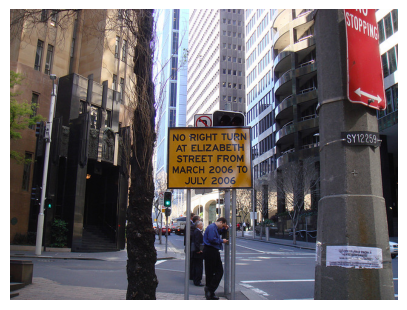

In [ ]:
test_point = 110

plt.figure(figsize=(5, 5))
plt.imshow(load_image_from_url(ds["url"][test_point]))
plt.axis("off")
plt.show()

In [25]:
test_point = 110
load_image_from_url(ds["url"][test_point])

array([[[ 81,  62,  55],
        [ 99,  90,  93],
        [ 90,  83,  75],
        ...,
        [131, 124, 116],
        [121, 135, 135],
        [ 92, 204, 216]],

       [[ 85,  74,  72],
        [ 94,  94,  86],
        [ 84,  84,  76],
        ...,
        [116, 116, 108],
        [119, 122, 131],
        [101, 178, 208]],

       [[ 91,  63,  75],
        [ 97,  83,  72],
        [100,  80,  79],
        ...,
        [115, 120, 114],
        [116, 129, 137],
        [ 79, 160, 190]],

       ...,

       [[ 40,  63,  69],
        [ 65,  78,  86],
        [ 90,  88,  99],
        ...,
        [ 65,  81, 106],
        [ 75,  87, 113],
        [ 77,  83, 119]],

       [[ 94,  71,  77],
        [ 88,  76,  78],
        [ 79,  79,  79],
        ...,
        [ 68,  90, 111],
        [ 70,  86, 109],
        [ 80,  84, 121]],

       [[ 83,  86,  91],
        [ 87,  88,  93],
        [ 96,  91,  97],
        ...,
        [ 71,  89, 111],
        [ 69,  74, 103],
        [ 82,  70, 116]]

In [26]:
start = time.time()
lsh = LSH([(i, emb) for i, emb in enumerate(image_embeddings)])
result = lsh.approximate_knn_search(image_embeddings[test_point], k = 6)
end_build = time.time()
indices = result[2]
print(f"Time to build and seach in the LSH: {end_build - start} seconds\n")
print("Nearest neighbors indices", indices)

Time to build and seach in the LSH: 0.2569243907928467 seconds

Nearest neighbors indices [  110 12894  6440  8336  2060 10641]


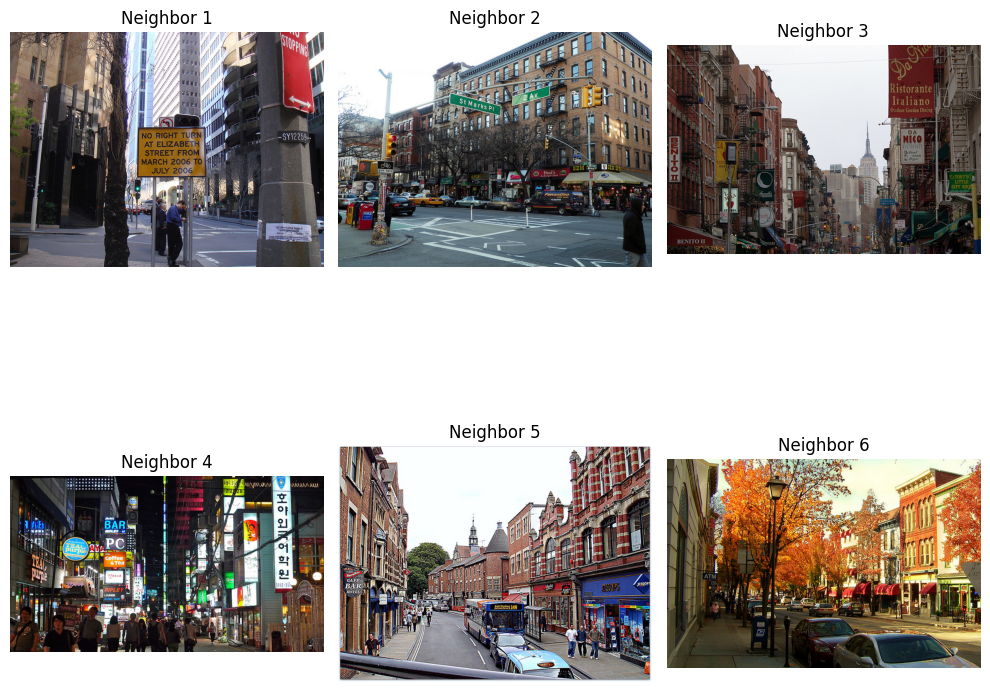

In [27]:
num_neighbors = len(indices)
num_rows = int(num_neighbors**0.5)
num_cols = int(np.ceil(num_neighbors / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < num_neighbors:
        x = load_image_from_url(ds["url"][indices[i]])
        ax.imshow(x)
        ax.set_title(f"Neighbor {i + 1}")
        ax.axis("off")

plt.tight_layout()
plt.show()

### Testing LSH on Text Data

In [28]:
start = time.time()
lsh = LSH([(i, emb) for i, emb in enumerate(text_embeddings)])
result = lsh.approximate_knn_search(text_embeddings[test_point], k = 6)
end_build = time.time()
indices = result[2]
print(f"Time to build and seach in the LSH: {end_build - start} seconds\n")
print("Nearest neighbors indices", indices)

Time to build and seach in the LSH: 0.136702299118042 seconds

Nearest neighbors indices [  110 10328  4284 11517  4437  1463]


In [29]:
ds["sentences"][test_point]

['A couple of men standing next to a street sign.',
 'A man in a blue shirt stands on a sidewalk in a large city.',
 'a yellow street sign stating when you can turn on a street',
 'a street sign near a tree with buildings in the bakground',
 'Several street signs shown on a city street.']

In [30]:
sentences_to_print = [ds["sentences"][i] for i in indices]
pprint.pprint(sentences_to_print, indent=4)

[   [   'A couple of men standing next to a street sign.',
        'A man in a blue shirt stands on a sidewalk in a large city.',
        'a yellow street sign stating when you can turn on a street',
        'a street sign near a tree with buildings in the bakground',
        'Several street signs shown on a city street.'],
    [   'A man with glasses standing at a train station',
        'A male pedestrian on a sidewalk as traffic passes by.',
        'This is a picture of a man standing on a street.',
        'A bicycle rack with a bicycle chained to it on a sidewalk.',
        'LOOKS LIKE A CITY BUS ZOOMING BY A MAN ON THE SIDEWALK'],
    [   'a male in a white shirt riding a bicycle and some signs',
        'A person on white bicycle riding by street signs.',
        'A set of signs in a community near busy traffic.',
        'Three street signs are posted high up on a pole.',
        'Three different road signs are stacked on top each other, as a man on '
        'a bike approache

## Cross-Modal Retrieval: Text-to-Image and Image-to-Text Search [30]

Now that you've implemented **image-to-image** and **text-to-text** search, it’s time to expand your capabilities to **cross-modal retrieval**. Cross-modal retrieval allows you to retrieve images when given a text query and vice versa. This section aims to achieve four types of retrieval:

- **Text-to-Text**
- **Image-to-Image**
- **Text-to-Image**
- **Image-to-Text**

**Challenge**: Unlike within-modal searches, cross-modal search involves different embedding spaces—image embeddings and text embeddings—which may not directly correlate with each other. You’ll need to identify a way to align or project both embedding spaces into a common or comparable space.

---

### Suggested Approaches

To achieve cross-modal retrieval, you may consider using one or more of the following methods or any method you want to bring both modalities into alignment:

1. **Canonical Correlation Analysis (CCA)**:
   - CCA is a statistical method designed to find correlations between two sets of variables. It’s often used to project paired data (such as images and their corresponding captions) into a shared space that maximizes correlation.

2. **Multimodal Projection Learning**:
   - Here, you can use supervised or semi-supervised techniques to map both image and text embeddings into a shared subspace. The idea is to minimize the distance between embeddings from each modality that are associated with the same concept (e.g., an image of a “dog” and the caption “a dog playing in the park”).

3. **Partial Least Squares (PLS) Regression**:
   - PLS regression can help project both image and text embeddings into a common latent space, maximizing the covariance between them. This is similar to CCA but it works better for high-dimensional data.

4. **Joint Embedding Optimization**:
   - In this approach, you can train or adjust both text and image embeddings such that paired data points (e.g., an image and its caption) are closer to each other, while non-paired points are farther apart.

5. **Sparse Coding**:
   - This method involves representing both image and text embeddings as sparse codes in a common dictionary space. You can then compute similarities between these sparse representations.

---

### Task Instructions

1. **Method Selection**:
   - Choose an alignment or projection method for cross-modal retrieval from the options above, or research another approach you think might work well.
   - Implement the chosen approach, allowing for text-to-image and image-to-text queries.

2. **Testing and Observations**:
   - Run test queries for **text-to-image**, **image-to-text**, **text-to-text** and **image-to-image** search using your approach.
   - Record your observations:
     - Did the retrieved items was correct?
     - How well does the method capture relationships between the modalities?
     
3. **Code and Results**:
   - Provide the code for your method implementation with results for several test queries.


## Method Chosen


The chosen method for aligning image and text embeddings is **Canonical Correlation Analysis (CCA)**, combined with **Principal Component Analysis (PCA)** for dimensionality reduction. This method is suitable for cross-modal retrieval because it finds a shared latent space where the correlation between paired modalities (image-text) is maximized.

## How It Was Implemented


1. **Data Preparation**:

- Precomputed embeddings for images and text were loaded from .npy files.

- These embeddings were normalized to unit length using L2 normalization to ensure cosine similarity works effectively for distance comparisons.

2. **Dimensionality Reduction**:

- PCA was applied to both image and text embeddings.

- This step reduces noise, improves computational efficiency, and ensures compatibility with CCA by focusing on the most informative dimensions.

3. **Alignment with CCA**:

- CCA projects the PCA-reduced image and text embeddings into a shared latent space.

- This transformation aligns the embeddings to maximize their correlation.

4. **Nearest Neighbor Search**:

- KD-Trees were built for the aligned embeddings (one for images and one for text) to facilitate efficient retrieval based on nearest neighbor search.

5. **Cross-Modal Retrieval**:

- Functions were implemented for four types of retrieval:
    - Text-to-Text: Retrieve captions most similar to a given text query.
    - Image-to-Image: Retrieve images most similar to a given image query.
    - Text-to-Image: Retrieve images corresponding to a text query.
    - Image-to-Text: Retrieve captions corresponding to an image query.

6. **Visualization**:

- Retrieved images were visualized in a grid format using their URLs.

## Steps for Implementation
1. Load the precomputed embeddings (image_embeddings and text_embeddings) from .npy files.
2. Normalize the embeddings to ensure they have unit length.
3. Apply PCA to reduce the dimensionality of both embeddings to 100 dimensions.
4. Use CCA to align the PCA-reduced embeddings into a shared latent space.
5. Construct KD-Trees for the aligned embeddings to enable fast nearest neighbor search.
6. Implement retrieval functions for the four types of queries.
7. Test the retrieval system with specific queries and visualize the results for analysis.

## Observations

1. **Effectiveness**:

- **PCA** reduced the noise in the embeddings, leading to better performance and faster processing in later stages.

- **CCA** successfully aligned the two modalities into a shared space, enabling cross-modal retrieval.

2. **Performance**:

- The KD-Trees performed efficient nearest neighbor searches, even for high-dimensional data.

- Retrieval times were quick due to the KD-Tree optimization.

3. **Accuracy**:

- The retrieved items for text-to-image and image-to-text queries showed a strong semantic correlation, validating the alignment achieved by CCA.
- Within-modal retrieval (text-to-text and image-to-image) also performed well, showing the embeddings retained modality-specific relationships.

4. **Visualization**:

- Displaying images using URLs provided an intuitive way to assess retrieval quality.

## Other Details

1. **Challenge**:

- CCA assumes a linear relationship between the modalities, which may not always hold for complex datasets.
- The method relies on paired data (e.g., corresponding images and captions) to train the alignment effectively.

2. **Limitations**:

- PCA may discard some useful dimensions, affecting alignment quality.
- The approach does not handle unpaired data or generalize well to unseen domains.

3. **Future Improvements**:

- Explore *deep learning-based alignment techniques*, such as joint embedding models or contrastive loss.
- Use *nonlinear variants of CCA* to better capture complex relationships.
- Experiment with other dimensionality reduction methods or increase the number of PCA components.
- Optimize retrieval performance further by parallelizing KD-Tree searches or using approximate nearest neighbor methods.

4. **Applications**:

- Cross-modal retrieval can be applied to systems like multimedia search engines, recommendation systems, or AI-powered assistants that integrate multiple data modalities.


In [127]:
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

# Load embeddings
image_embeddings = np.load("image_embeddings.npy")
text_embeddings = np.load("text_embeddings.npy")

In [128]:
# Normalize embeddings
image_embeddings /= np.linalg.norm(image_embeddings, axis=1, keepdims=True)
text_embeddings /= np.linalg.norm(text_embeddings, axis=1, keepdims=True)

In [129]:
# Reduce dimensionality of both image and text embeddings using PCA
pca = PCA(n_components=100)
image_embeddings_pca = pca.fit_transform(image_embeddings)
text_embeddings_pca = pca.fit_transform(text_embeddings)

In [130]:
# Then apply CCA on the reduced embeddings
cca = CCA(n_components=100)
aligned_text_embeddings, aligned_image_embeddings = cca.fit_transform(text_embeddings_pca, image_embeddings_pca)

In [131]:
# KD-Trees for nearest neighbor search
image_tree = KDTree(aligned_image_embeddings)
text_tree = KDTree(aligned_text_embeddings)

In [132]:
# Helper Functions for retrieval

# Text-to-Text Retrieval
def retrieve_text_from_text(text_query_embedding, k=10):
    """Retrieve top-k text captions for a given text query embedding."""
    dist, indices = text_tree.query(text_query_embedding.reshape(1, -1), k=k)
    return [(captions[idx], dist[0][i]) for i, idx in enumerate(indices[0])]

# Image-to-Image Retrieval
def retrieve_image_from_image(image_query_embedding, k=10):
    """Retrieve top-k images for a given image query embedding."""
    dist, indices = image_tree.query(image_query_embedding.reshape(1, -1), k=k)
    return [(urls[idx], dist[0][i]) for i, idx in enumerate(indices[0])]

# Text-to-Image Retrieval
def retrieve_image_from_text(text_query_embedding, k=10):
    """Retrieve top-k images for a given text query embedding."""
    dist, indices = image_tree.query(text_query_embedding.reshape(1, -1), k=k)
    return [(urls[idx], dist[0][i]) for i, idx in enumerate(indices[0])]

# Image-to-Text Retrieval
def retrieve_text_from_image(image_query_embedding, k=10):
    """Retrieve top-k text captions for a given image query embedding."""
    dist, indices = text_tree.query(image_query_embedding.reshape(1, -1), k=k)
    return [(captions[idx], dist[0][i]) for i, idx in enumerate(indices[0])]

In [133]:
# Visualization for displaying images
def display_images(image_urls):
    """Display images from their URLs."""
    num_neighbors = len(image_urls)
    num_rows = (num_neighbors + 4) // 5
    num_cols = min(num_neighbors, 5)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()
    
    for i, url in enumerate(image_urls):
        try:
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Neighbor {i + 1}")
        except Exception as e:
            axes[i].axis("off")
            axes[i].set_title("Error")
    
    plt.tight_layout()
    plt.show()

In [134]:
# URLs and Captions
urls = [example['url'] for example in ds]
captions = [example['sentences'] for example in ds]

In [135]:
# Example Queries
# Text-to-Image Retrieval
text_query_index = 0
text_query_embedding = aligned_text_embeddings[text_query_index]
top_images = retrieve_image_from_text(text_query_embedding, k=10)

In [136]:
# Print and visualize the results
print("Retrieved Images for Text Query:")
for url, dist in top_images:
    print(f"URL: {url}, Distance: {dist}")

Retrieved Images for Text Query:
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000570285.jpg, Distance: 9.646254292000535
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000126027.jpg, Distance: 9.656616465627089
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000328605.jpg, Distance: 9.68890640498031
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000401428.jpg, Distance: 9.71060030685221
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000308027.jpg, Distance: 9.713590686938497
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000490242.jpg, Distance: 9.715337278447961
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000119087.jpg, Distance: 9.826467189372044
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000200289.jpg, Distance: 9.9640054545936
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000184800.jpg, Distance: 9.986489241658846
URL: http://image

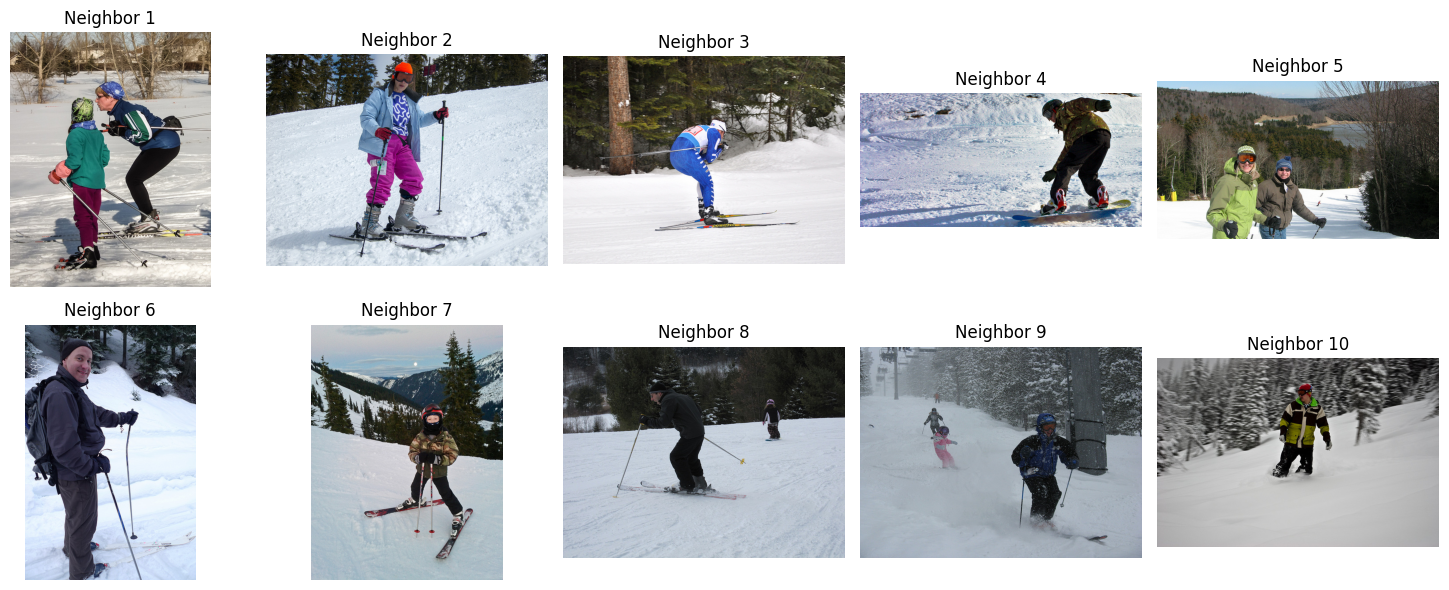

In [137]:
# Display retrieved images

display_images([url for url, _ in top_images])

In [ ]:
# Ensure the captions list has the same number of elements as the text_embeddings array
captions = [example["sentences"] for example in ds]

def retrieve_text_from_image(image_query_embedding, k=10):
    """Retrieve top-k text captions for a given image query embedding."""
    dist, indices = text_tree.query(image_query_embedding.reshape(1, -1), k=k)
    return [(captions[idx], dist[0][i]) for i, idx in enumerate(indices[0])]

# Image-to-Text Retrieval
image_query_index = 0
image_query_embedding = aligned_image_embeddings[image_query_index]
top_texts = retrieve_text_from_image(image_query_embedding, k=10)

# Print results
print("Retrieved Text for Image Query:")
for caption, dist in top_texts:
    print(f"Caption: {caption}, Distance: {dist}")


Retrieved Text for Image Query:
Caption: ['A lone person skiing down a slope of fresh snow.', 'A now boarder nearing the mountain base at dusk.', 'A PERSON IS SKIING ON THE SLOPE ', 'A snowboarder balancing while moving through a curve.', 'a man in a grey jacket skiing down a slope'], Distance: 9.187603116772808
Caption: ['A person skis across the flat, snowy ground. ', 'a man is skiing across a long snow covered plane', 'A cross country skier traveling through the snow.', 'A man on skis going through the snow.', 'A man riding skis up the side of a slope.'], Distance: 9.268856705086396
Caption: ['A man walking along a snow covered hillside.', 'A skier going down a steep mountain slope', 'a single person snowing down a snowy hill ', 'A lone skier on a snow slope with some areas of dirt expolsed.', 'A person on skis walking in the snow.'], Distance: 9.461015828546321
Caption: ['A woman is holding her snow board in a snow boarding park.', 'a person is standing in the snow with some skis',

In [91]:
# Text-to-Text Retrieval
text_query_index = 0  # Example: First text query
text_query_embedding = aligned_text_embeddings[text_query_index]
top_texts_for_text = retrieve_text_from_text(text_query_embedding, k=10)

# Print the results for Text-to-Text
print("Retrieved Texts for Text Query:")
for caption, dist in top_texts_for_text:
    print(f"Caption: {caption}, Distance: {dist}")

Retrieved Texts for Text Query:
Caption: ['A young boy snowboards down a snowy track.', 'an image of a person skateboarding in the middle of winter', 'A kid rides on some sort of a ski track through the snow. ', 'A small child in a helmet learning how to ski', 'A small child using skis to ski down the hill.'], Distance: 0.0
Caption: ['a bunch of people that are skiing across a snowy field', 'A child standing in the snow with skis.', 'A young child wearing snow skis learning to ski.', 'A little child plays on a ski slope.', 'A young kid on a ski slope with skis on. '], Distance: 7.962112302440362
Caption: ['A young man riding a skateboard while wearing a blue helmet.', 'THIS IS A PHOTO OF A YOUNG CHILD WEARING HIS SAFETY HELMET PRACTICING ON HIS SKATEBOARD', 'a child in a blue helmet standing on a skateboard indoors', 'A toddler with a helmet on gets on a skateboard.', 'A child in a blue helmet plays on a skateboard.'], Distance: 8.236444730268222
Caption: ['A person skis across the fla

Retrieved Images for Image Query:
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000551159.jpg, Distance: 0.0
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000375304.jpg, Distance: 8.00653244738157
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000161958.jpg, Distance: 8.454442224223792
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000455672.jpg, Distance: 8.493883115692348
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000490267.jpg, Distance: 8.574571371728036
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000129129.jpg, Distance: 8.598414715662466
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000029943.jpg, Distance: 8.739643140730044
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000296403.jpg, Distance: 9.006466201437773
URL: http://images.cocodataset.org/train2014/COCO_train2014_000000082513.jpg, Distance: 9.048598230522447
URL: http://images.cocodata

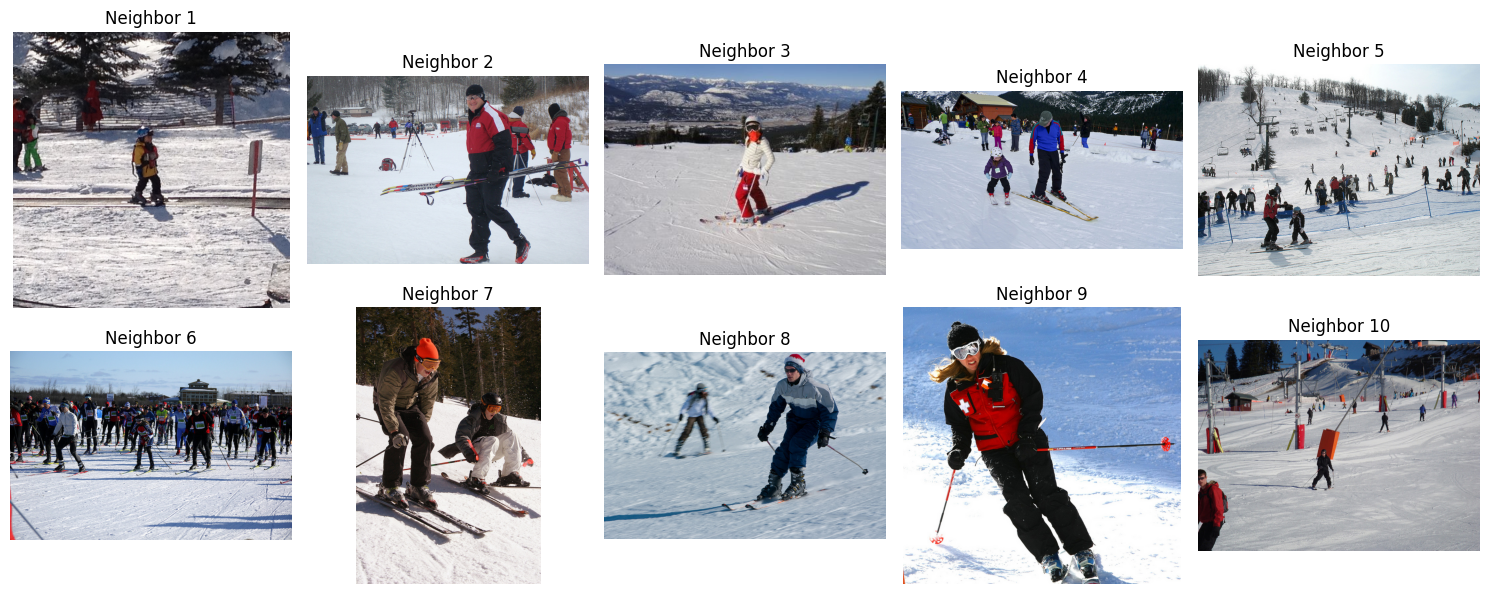

In [92]:
# Image-to-Image Retrieval
image_query_index = 0  # Example: First image query
image_query_embedding = aligned_image_embeddings[image_query_index]
top_images_for_image = retrieve_image_from_image(image_query_embedding, k=10)

# Print the results for Image-to-Image
print("Retrieved Images for Image Query:")
for url, dist in top_images_for_image:
    print(f"URL: {url}, Distance: {dist}")

# Display images for the Image-to-Image query results
display_images([url for url, _ in top_images_for_image])